# <font color='darkblue'>ASTR 21100 

# <font color='darkblue'>"Computational Techniques in Astrophysics"

## <font color='darkblue'>Sampling multi-dimensional distributions with MCMC
## <font color='darkblue'>Using MCMC in maximum likelihood/Bayesian analysis
    
## <font color='darkblue'>Instructor: Andrey Kravtsov

### <font color='darkblue'>email: kravtsov@uchicago.edu

In [8]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier, plot_2d_dist
plot_prettier()

### <font color='darkblue'>Using MCMC in the Maximum Likelihood and Bayesian sampling</font>

One of the main applications of the MCMC sampling is in statistical inference of model parameters given a set of measurements (data). 


### <font color='darkblue'>The likelihood pdf of data given a model</font>

Suppose our model for the distribution of data points (measurements) of some quantities $x$ and $y$ in the $x-y$ plane is given by a function $y_m=f(x, \vec{\theta})$, where $\vec{\theta}$ is a vector of model parameters.  

This model assumes that uncertainties of measurements in both $x$ and $y$ measurements, $\sigma_x$ and $\sigma_y$, can be described by Gaussian pdfs. In this case, the overall uncertainty if the difference between measurement $(x,y)$ and model prediction $y_{\rm m}$ is the uncertainty of the residual $r=y-y_m$, which is computed by error propagation:

$$\sigma\approx \sqrt{\sigma_y^2\left(\frac{\partial r}{\partial y}\right)^2 + \sigma_x^2\left(\frac{\partial r}{\partial x}\right)^2}.$$ 

This uncertainty $\sigma_i$ can be computed for each measurement $i$ in the dataset, where $\sigma_x$ and $\sigma_y$ will be uncertainty of that specific measurement and derivatives of $r$ are evaluated at the datapoint $i$.  


**Likelihood pdf for a single measurement with Gaussian uncertainties.** The assumption of Gaussian uncertainties defines the probability density function for a *single* measurement $y_i$ given the correctness of the model $y_m$:  

$$p(x_i,y_i\vert y_m)=p(x_i,y_i\vert \vec{\theta})={1\over \sqrt{2\pi \sigma^2_{i}}}\,\exp\left[-{1\over 2}\,\frac{(y_i-y_m)^2}{\sigma_{i}^2}\right]$$

Vertical line $\vert$ denotes that pdf depends on (conditioned on) something. However, the pdf itself  is the pdf of $x_i, y_i$ in the $x-y$ plane. Thus probability or *likelihood*  $p(x_i, y_i\vert \vec{\theta})dy$ that measured values $x_i$ and $y_i$ are expected in the area defined by $[x_i,x_i+dx]$ and $[y_i,y_i+dy]$, given the model and its parameters. 



**Likelihood pdf for a collection of measurements.** If we assume that different measurement pairs $(x_i,y_i)$ with different $i$ are independent (i.e., uncorrelated), the probability of all the $y$ measurements given the model and its parameter value is given by the product of individual probabilities: 

$$P({\rm data}\vert {\rm model}) = {\rm probability_{\rm y_0}}\times {\rm probability_{\rm y_1}}\,\ldots\,\times\,{\rm probability}_{y_{n-1}}$$

or, more mathematically: 

$$P({\rm data}\vert {\rm model}) = P(\vec{x},\vec{y}\vert y_m) = p(x_0,y_0\vert y_m)\,p(x_1,y_1\vert y_m)\,\ldots\, p(x_{n-1},y_{n-1}\vert y_m)\,dx^ndy^n$$

where $\vec{x}=[x_0,x_1,\ldots,x_{n-1}]$, $\vec{y}=[y_0,y_1,\ldots,y_{n-1}]$ are vectors of $x$ and $y$ measurement values. 

The probability $P({\rm data}\vert {\rm model})$ is called ***the likelihood function*** (or just ***the likelihood***) of measurement data given the model and is often denoted by $L$: 

$$L({\rm data}\vert {\rm model}):= P({\rm data}\vert {\rm model})$$

**Log likelihood for measurements with Gaussian uncertainties.** Given that the likelihood is a product of many Gaussian pdfs (each corresponding to a different measurement), it can become numerically very small and cause underflow of floating pont operations. For this reason, in this method the natural logarithm of $L$, $\ln L$ is used instead of $L$. This does not change the result, because $\ln L$ is maximized when $L$ is maximized and vice versa. 

$$\ln L(\vec{y}\vert y_m) = \ln \left\{{1\over \sqrt{2\pi \sigma^2_{0}}}\,\exp\left[-{1\over 2}\,\frac{(y_0-y_m)^2}{\sigma_{0}^2}\right]\times \ldots\times {1\over \sqrt{2\pi \sigma^2_{n-1}}}\,\exp\left[-{1\over 2}\,\frac{(y_{n-1}-y_m)^2}{\sigma_{n-1}^2}\right]\right\}$$

Remembering that $\ln xy = \ln x + \ln y$, we have multiple products here...  

First (taking into account that $\ln e^x = x\ln e=x$): 

$$\ln \left\{\frac{1}{\sqrt{2\pi} \sigma_{0}}\,\exp\left[-{1\over 2}\,\frac{(y_0-y_m)^2}{\sigma_{0}^2}\right]\right\}= \ln{1\over \sqrt{2\pi}} - \ln\sigma_{0}-{1\over 2}\,\frac{(y_0-y_m)^2}{\sigma_{0}^2}$$

we get $\ln L$ expression:

$$\ln L(\vec{y}\vert \vec{\theta}) = n\ln{1\over \sqrt{2\pi}} - \sum\limits_{i=0}^{n-1}\ln\sigma_{i}-{1\over 2}\,\sum\limits_{i=0}^{n-1}\frac{(y_i-y_m)^2}{\sigma_{i}^2}=n\ln{1\over \sqrt{2\pi}} - {1\over 2} \,\sum\limits_{i=0}^{n-1}\ln\sigma_{i}^2-{1\over 2} \,\sum\limits_{i=0}^{n-1}\left(\frac{r_i}{\sigma_{i}}\right)^2,$$

where $r_i=y_i-y_m(x_i,\vec{\theta})$. 


$\ln{n\over \sqrt{2\pi}}$ is just a constant for a given data set so don't really need to be included for MCMC sampling, which does not depend on the constant normalization of the distribution.

### <font color='darkblue'>The maximum likelihood method</font>

consists of finding the combination of model parameters that ***maximize the value of the likelihood***. In other words, the parameters $\tilde{b}$, $\tilde{c}$ for which model is assumed to be the best description of the data are those for which 

$$L(\vec{y}\vert \tilde{b},\tilde{c})= L_\max=\max\limits_{b,c}L(\vec{y}\vert b,c)$$

Thus, finding these parameter values is an *optimization problem*.

Finding best-fit parameter values is only a fraction of what constitutes statistical inference. The second and most important part is estimating uncertainties of the parameters. These uncertainties are also defined using likelihood pdf, as will be illustrated below. 

### <font color='darkblue'>Specific example: linear model</font>

We will consider a simple, but commonly encoutered in practic case of the *linear model*: $y_m=bx +c + \epsilon$, where $\epsilon$ is the random number drawn from the Gaussian pdf with zero mean and standard deviation $e$. 

This model assumes that uncertainties of measurements in both $x$ and $y$ measurements, $\sigma_x$ and $\sigma_y$, can be described by Gaussian pdfs. In this case, the overall uncertainty if the difference between measurement $(x,y)$ and model prediction $y_{\rm m}=bx + c$ is the uncertainty of the residual $r=y-bx-c$, which by propagation of error is $\sigma\approx \sqrt{\sigma_y^2 + b^2\sigma_x^2}$. 

The model defines the probability density function for a measurement $y_i$, 

$$p(y_i\vert y_m)=p(y_i\vert b,c)={1\over \sqrt{2\pi \sigma^2_{i}}}\,\exp\left[-{1\over 2}\,\frac{(y_i-y_m)^2}{\sigma_{i}^2}\right].$$

For the entire set of measurement the log of the likelihood is 

$$\ln L(\vec{y}\vert b,c) = n\ln{1\over \sqrt{2\pi}} - \sum\limits_{i=0}^{n-1}\ln\sigma_{i}-{1\over 2}\,\sum\limits_{i=0}^{n-1}\frac{(y_i-y_m)^2}{\sigma_{i}^2}=n\ln{1\over \sqrt{2\pi}} - {1\over 2} \,\sum\limits_{i=0}^{n-1}\ln\sigma_{i}^2-{1\over 2} \,\sum\limits_{i=0}^{n-1}\left(\frac{r_i}{\sigma_{i}}\right)^2,$$


### <font color='darkblue'>Mock data set for testing the model inference</font>


The functions below generate a mock data set that follows a linear relation with specified slope and intercept (<tt>btrue, ctrue</tt>) and uncertainties in both $x$ and $y$ variables. Given that we know what the true values of $b$ and $c$ are for the mock dataset generated in this way, we can use the data to test the model. 

In [4]:
def generate_mock_data(xlims, ex, ey, btrue=3, ctrue=3.481, nr = 2000):
    xr = np.random.uniform(xlims[0], xlims[1], size=nr) 

    exr = np.random.normal(scale=ex, size=nr)
    eyr = np.random.normal(scale=ey, size=nr)

    yr = btrue * xr + ctrue + eyr
    xr = xr + exr
    
    return xr, exr, yr, eyr

In [5]:
def plot_mock_data(xr, yr, exr=None, eyr=None, 
                   btrue=None, ctrue=None, figsize=(5,5)):
    # plot mock data
    plt.figure(figsize=figsize)
    plt.errorbar(xr, yr, xerr=exr, yerr=eyr, fmt='o', alpha=0.5, color='darkslateblue')
    plt.xlabel(r'x')
    plt.ylabel('y')
    xf = np.linspace(xr.min(), xr.max(), 10)
    plt.plot(xf, btrue * xf + ctrue, '--', c='orangered', label='true model')
    plt.legend(loc='best')
    plt.show()

Function below computes $\ln L$ given by expression above for input values of $c$ and $b$ and data set passed through <tt>args</tt>

In [6]:
def loglin_like(p, *args):
    """
    ln of linear model likelihood

    Parameters:
    -----------
    p - real 1d numpy vector of size 3 
        values of the model parameters, c, m, intrinsic scatter in y direction
    args is a list of numpy arrays in this order: 
        x - real 1d numpy vector
            x values of data, array size = number of data points ndata
        y - real 1d numpy vector
            y values of data of the same size as x 
        sigx - real 1d numpy vector of size x
            Gaussian st dev of x
        sigy - real 1d numpy vector of size 
            Gaussian st dev of y

    Returns:
    --------
    a real number 
        ln(Likelihood of linear model with intrinsic Gaussian scatter in y direction)
    """
    x, y, sigx, sigy = args
    sigtot2 = sigy**2 + (p[1]*sigx)**2
    
    # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
    return np.sum(-0.5 * (np.log(sigtot2) + (y - p[0] - p[1]*x)**2 / sigtot2))
    

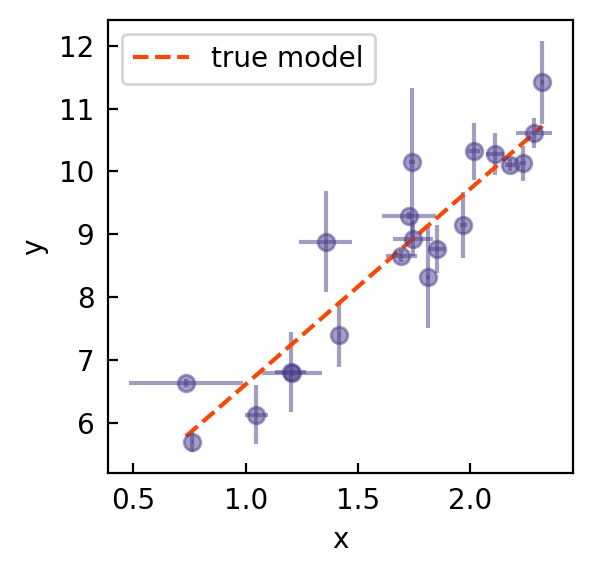

In [10]:
# generate mock data with a given slope and intercept
nr = 20 # number of data points to generate
btrue, ctrue = 3.11, 3.5
ex, ey = 0.1, 0.5
xr, exr, yr, eyr = generate_mock_data([0.7, 2.5], ex, ey, btrue=btrue, ctrue=ctrue, nr=nr)

plot_mock_data(xr, yr, exr=exr, eyr=eyr, btrue=btrue, ctrue=ctrue, figsize=(3,3))

In [13]:
def mcmc_simple(x0, nsteps, step, logpdf, *args):
    """
    a simple implementation of the Metropolis MCMC algorithm
    implements steps using a uniformly distributed random number in the range [-step,step]

    Parameters:
    -----------
    x0:     1d numpy array of floats (size = number of dimensions), initial point
    nsteps: integer, the number of steps to make
    step:   float, step size normalization
    logpdf: Python function object for the ln(pdf) function
    args:   list, a list of arguments to pass to logpdf (can be empty)
    
    Returns:
    --------
    chain: list of size nsteps, containing all recorded steps 
    """
    x = x0 
    nparams = np.size(x0) # dimensionality of distribution we are sampling
    fnow = logpdf(x, *args) # compute current value of ln(pdf)
    
    chain = [] # initialize chain list
    for nstep in range(nsteps):
        xtry = x + step * np.random.uniform(-1, 1., size=nparams)
        ftry = logpdf(xtry, *args)
        if ftry > fnow:
            x = xtry
            fnow = ftry
        else: 
            u = np.random.uniform()
            if np.log(u) < ftry - fnow:
                x = xtry
                fnow = ftry
                
        chain.append(x)
        
    return chain

In [14]:
ndim = 2
nsteps = 100000
x0 = [3.5, 3.] # start at the true values of the parameters
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

Plot parameter values sampled in the MCMC chain in the $c-b$ plane as 2D histogram. The contours are defined by the values in the list <tt>conflevs</tt>, which are chosen to encose $68.27\%$ and $95.45\%$ of samples, which approximately corresponds to $1-\sigma$ and $2-\sigma$ of the 1D Gaussian pdf. Such contours are referred to as $1-\sigma$ and $2-\sigma$ contours. 

The true values of the slope and intercept are shown by red cross. We get unbiased values of the parameters if the sampled likelihood pdf is within these contours. If  regenerate the mock data set again and again and redo the sampling each time, we should see that the true value should be within $1\sigma$ contour about $68.25\%$ of the time (try this!). 

C:\Users\akrav\Documents\Classes\a211s22\codes\plotting.py:322: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls),


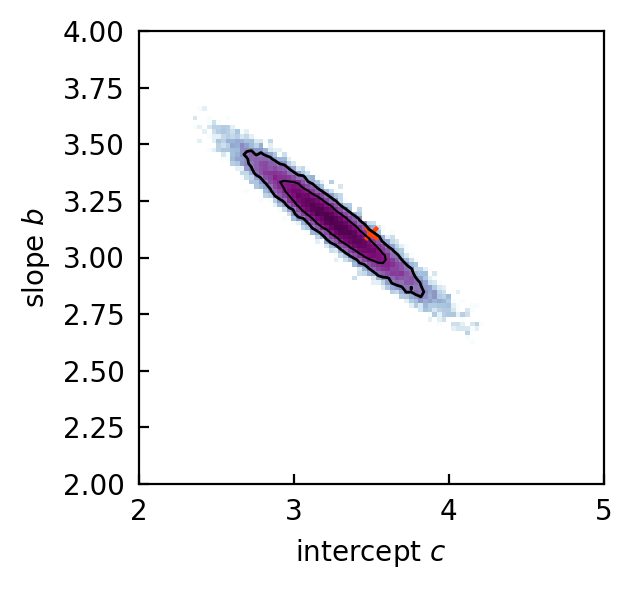

In [15]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[2,5], ylim =[2.,4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

We can see that distribution of $b$ and $c$ values looks like a 2-dimensional Gaussian. The true value of the parameters is close to the peak of the distribution. This means that we *infered* parameter values from the mock data without bias. The values of $b$ and $c$ of the chain element that maximizes the likelihood can be taken as "best-fit" parameter values. If the distribution is close to Gaussian (symmetric) a simple median of the values can be used as a parameter estimates. These will be somewhat different from true values because parameter inference has uncertainty that is reflected in the width of the distribution above.  

The confidence intervals of $b$ and $c$ can be obtained by determined by finding their value range that encloses a given fraction of the samples. For example, contours in the plot above enclose $68.27%$ and $95.45%$ of the samples are this is what usually referred to as $1-\sigma$ and $2-\sigma$ contours (one can add more contours if outer parts of the distribution are well sampled. 

In [18]:
def clims(a):
    '''
    compute confidence limits given a given percentile a
    '''
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = clims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = clims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for the {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [20]:
chain_stats(chain[:,0], param_name='intercept')
chain_stats(chain[:,1], param_name='slope')

============ statistics for the intercept ============
mean, median = 3.271, 3.269, st.dev=0.2306
68 perc interval = 3.043, 3.500
95 perc interval = 2.811, 3.740
============ statistics for the slope ============
mean, median = 3.168, 3.168, st.dev=0.1254
68 perc interval = 3.043, 3.292
95 perc interval = 2.914, 3.420


### <font color='darkblue'>Importance of the starting point and burn-in

You may have noticed that the MCMC sampling above was started at the true values of the parameters. 
This is the luxury we may not have. 
    
Recalculation below shows what happens when we start at values pretty far from the true ones. 

In [21]:
ndim = 2
nsteps = 100000
x0 = [0, 1.] # start at the true values of the parameters
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

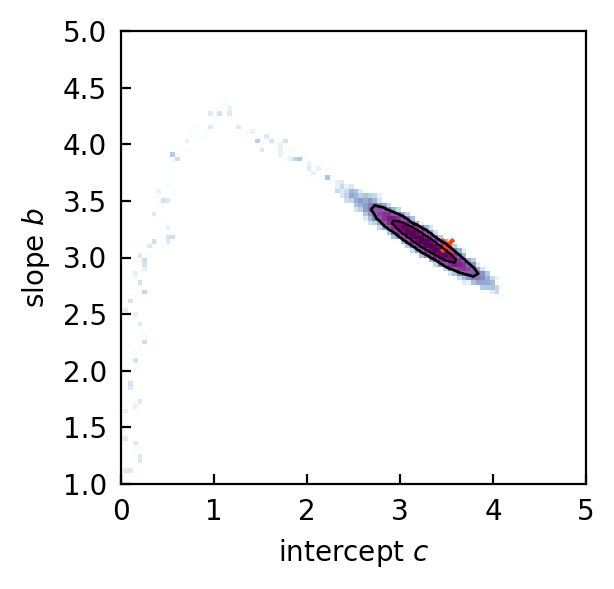

In [22]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[0,5], ylim =[1.,5], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

We can see that the chain recovers, but there is a fairly sizeable initial portion of the chain where samples do not follow the Gaussian pdf. This is the "burn-in" part of the chain. If it is not removed, it can potentially bias our estimates of quantities such as mean values of parameters. 

Burn-in can be minimized if we start from the initial values of parameters that are close to the maximum of the distribution. Thus, it helps to know where this maximum is. Finding extrema of functions is handled by ***optimization methods***, which we discussed, and as was shown above.

Here is an example using SciPy's differential evolution function. Here we define minus log likelihood  because we will use function that finds minimum to find maximum:

In [28]:
def minus_loglin_like(x, *args):
    '''
    define minus log likelihood because we will use function that finds minimum to find maximum
    '''
    return -loglin_like(x, *args)

In [32]:
from scipy.optimize import differential_evolution

args = [xr, yr, exr, eyr]
bounds = [[1,5],[1,5]]

res = differential_evolution(minus_loglin_like, bounds=bounds, args=args)

print(f'The best fit intercept and slope values: c = {res.x[0]:.3f}, b = {res.x[1]:.3f}')

The best fit intercept and slope values: c = 3.290, b = 3.157


This illustrates that just knowing the values that maximize likelihood is not particularly meaningful: intecept and slope are not exactly equal to their true values, but we don't know whether this means that our inference is wrong or is this because these values are uncertain due to uncertainties in the data. To answer this question we need to estimate confidence limits on the parameters as was shown above. 

## <font color='darkblue'>Bayesian approach
    
Bayesian approach is based on 
**the Bayes theorem**:

$$p({\rm model\vert data})=\frac{p({\rm data}\vert {\rm model})\,p({\rm model})}{p({\rm data})}$$


which, in turn, is a consequence of the usual chain rule of joint probability of data and model: 

$$p({\rm data,\ model}) = p({\rm model}\vert {\rm data})\,p({\rm data}) = p({\rm data}\vert {\rm model})\,p({\rm model})$$

As mentioned before, the probability of data given the model $p({\rm data}\vert {\rm model})$ is usually called ***the likelihood*** in statistical analyses: 

$$L({\rm data}\vert {\rm model}) := p({\rm data}\vert {\rm model})$$


So Bayesian approach differs from the maximum likelihood method by multiplication of the likelihood by the prior pdf's of model parameters. 


###  <font color='darkblue'>Note:
    
When dealing with conditional probabilities, it's useful to remember that
probability distributions have dimensions to make sure that they are used correctly. A given pdf measures *density* of probability per length of the interval, so $p(x)$ has dimension of $x^{-1}$ so that $p(x)dx$ is dimensionless and gives probability of $x$ to be in $[x,x+dx]$. Likewise, $p(x,y)$ has dimensions of $x^{-1}y^{-1}$.

Conditional pdf notation may be a bit confusing in this regard, but the key is that dimensionality of pdf only depends on the variables to the left of $\vert$, so $p(x|y)$ has dimension $x^{-1}$, $p(x,y|z)$ has dimensions $x^{-1}y^{-1}$ etc. 
    
It's useful to remember this, because then it can be used to check expressions involving probability. 
Thus, for example, $\int p(x|y)dx$ is a dimensionless probability, if $p$ is a properly normalized pdf, while $\int p(x|y)dy$ is not because it has dimensions of $[y/x]$.

The Bayes theorem reflects dimensionalities of the pdfs that enter into its expression. For example:

$$p(x|y) = \frac{p(y|x)p(x)}{p(y)}.$$

If we compute dimensions of pdf on the left and expression on the right hand side, they will both have dimension of $x^{-1}$. 

###  <font color='darkblue'>Prior distributions for the linear model


If we have good reasons to think that slope and intercept should be within a given range, then priors corresponding to that range should be defined. However, if we don't really know what values to expect, then prior distributions can be inferred via the following considerations. 

 Slope $b$ varies from zero to infinity, and uniform prior in $b$ would thus assign a lot of probability to large $b$ values, which can bias inferred $m$ values high. Most natural assumption is thus that angle formed by the line and say $x$ axis is uniformly distributed  $\alpha\in[-\pi/2,\pi/2]$, where $b=\tan\alpha$. Differential $db=d\alpha/\cos^2\alpha=d\alpha(1+b^2)$. Thus, uniform prior on $\alpha$ implies 
 
$$p(\alpha)d\alpha={\rm const}\ \ \ \rightarrow\ \ \ \ p(b)\propto \frac{db}{1+b^2}.$$
 
A somewhat trickier, but not overly complicated consideration (see your notebook) also suggests that the prior pdf of $c$ should be 

$$p(c)\propto \frac{1}{\sqrt{1+b^2}},$$

so that 

$$p(c,b)\propto \frac{1}{(1+b^2)^{3/2}}.$$

**Note:** it is natural to assume uniform prior not in $c$, because $c$ depends on the particular choice of axis $y$, which will change if reference frame is rotated, but distance from the line to the origin $(x,y)=(0,0)$, $c_\perp=c\cos\alpha=c/\sqrt{1+b^2}$, which is invariant to rotation of the frame. Then $dc_\perp = dc/\sqrt{1+b^2}$ and uniform prior in $dc_\perp$ implies 

$$p(c)\propto \frac{1}{\sqrt{1+b^2}},$$

so that 

$$p(c,b)\propto \frac{1}{(1+b^2)^{3/2}}.$$

This prior can also be formally derived by requiring that $p(c,b)$ functional form is symmetric to switch of $x$ and $y$ axes. Prior pdfs above are expressed as proportionalities without normalization constants. These constants do not matter for MCMC sampling because it is not sensitive to the constant normalization of the sample distribution. 


### <font color='darkblue'>Posterior pdf
    
In the Bayesian approach instead of finding the maximum of and sampling the likelihood function we sample the posterior pdf given by the product of the likelihood function and prior pdfs of parameters. 
    
Thus, for the linear model posterior pdf is:
    
$$\pi(b,c\vert \vec{d}) = L(\vec{d}\vert b,c) p(b)p(c).$$
    
where $\vec{d}$ includes all data $\vec{d}=\{\vec{x},\vec{y},\vec{\sigma}_x,\vec{\sigma}_y\}$. This posterior distribution is not properly normalized to be a pdf because we ignore factor $Z=1/p(\vec{d})$.  This factor is called *the evidence* in Bayesian analysis. MCMC sampling is not sensitive to distribution normalization, but calculation of evidence is important for Bayesian model comparison (see below).  
    
As for likelihood, for numerical stability we sample $\ln\pi$ instead of $\pi$:

$$\ln \pi(b,c\vert \vec{d}) = n\ln{1\over \sqrt{2\pi}}  - {1\over 2} \,\sum\limits_{i=0}^{n-1}\ln\sigma_{i}^2-{1\over 2} \,\sum\limits_{i=0}^{n-1}\left(\frac{r_i}{\sigma_{i}}\right)^2 + \ln p(c) + \ln p(b),$$

The constant factor $n\ln{1/\sqrt{2\pi}}$ is not important for MCMC sampling itself, which is not sensitive to constant normalization factors, but it is important for estimating Bayesian evidence or BIC criterion described below. 

## <font color='darkblue'>Example: linear model with intrinsic scatter</font>
    
## <font color='darkblue'>Testing Modified Newtonian Dynamica (MOND) model using Baryonic Tully-Fisher relation and Bayesian statistics


**Background.** Galaxies are large collections of gas and stars. Interstellar gas and stars in the "spiral" (aka "disk") galaxies like our Milky Way or [NGC 6384 galaxy](http://astrodvorek.cz/Pics/N6384_1n.jpg) rotates around the center with a velocity that is correlated with the total mass, $M$, of gas and stars in that galaxy. This relation is called the ["Tully-Fisher relation" (TFR)](https://en.wikipedia.org/wiki/Tully%E2%80%93Fisher_relation) in honor of the two astronomers, Brent Tully and Richard Fisher, who discovered it in 1977.   Our Sun, for example, is moving on a nearly circular orbit around the center of the Milky Way with the "***rotation velocity***" of $\approx 220$ km/sec. 

The relation can be approximated by the "power-law form": $M=a v_{\rm rot}^b.$ Such form becomes linear for the logarithms of the mass and rotation velocity: 

$$\log_{10} M = b\log_{10} v_{\rm rot} + \log_{10}a = b\log_{10} v_{\rm rot} + c,$$

and thus we can measure the slope $b$ and "*intercept*" $c$ of this relation using measurements for a sample of galaxies. 

In this exercise you will examine this correlation in the form of logarithms of the mass and logarithm of rotation velocity using modern measurements (from the paper by [Bradford et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...832...11B/abstract)). You will use your estimate of the slope $b$ and its uncertainty to test the [Modified Newtonian Dynamics (MOND)](https://en.wikipedia.org/wiki/Modified_Newtonian_dynamics) model that predicts that the slope of the linear relation is exactly $4$, while the constant $c$ in this model is predicted to be the fundamental constant of nature $c=-\log_{10} Ga_0$ where $G$ is the Newton's gravitational constant and $a_0$ is the universal acceleration assumed in that model. 

The code below reads in measurements $\log_{10} M$ and $v_{\rm rot}$ and prepares them for analysis. The final numbers for regression are put in variables $x=\log_{10} v_{\rm rot}$ and $y=\log_{10} M$  and  their uncertainties (standard deviations), $s_y$ and $s_x$. 


In [33]:
from astropy.io import fits

url = 'http://astro.uchicago.edu/~andrey/classes/a205/data/bradford16_fig1.fits'
b16 = fits.getdata(url)

# width of the HI 21 cm line = proxy for rotation velocity in km/s
vrot = b16['VW20I']; 
# error of W20b
evrot = b16['VW20I_ERR']
# log of Vrot
x = np.log10(vrot)
# approximate log error
ex = 0.5*(np.log10(vrot+evrot) - np.log10(np.maximum(vrot-evrot,1.e-10)))

# log10 of the gas mass and star mass (aka the "baryons")
y = b16['MBARYON']; 
# error of log10(gas+stars mass)
ey = b16['MBARYON_ERR']

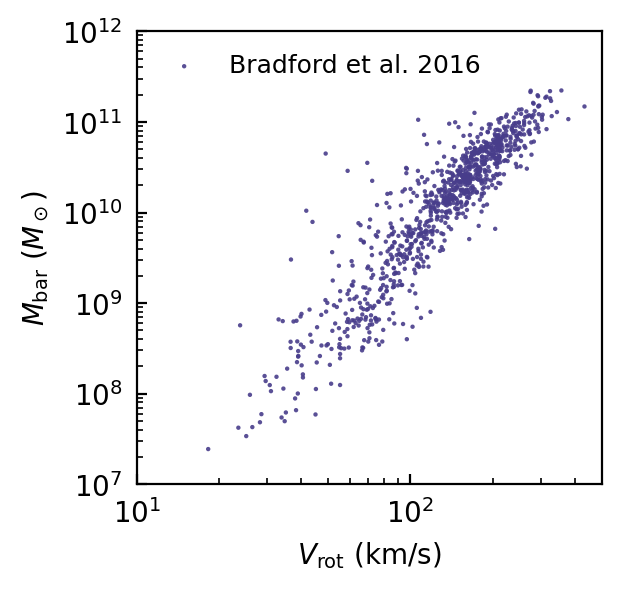

In [34]:
plt.figure(figsize=(3.,3.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([10.,500.]); plt.ylim([1.e7,1.e12]) 
plt.xlabel(r'$V_{\rm rot}\rm\ (km/s)$'); plt.ylabel(r'$M_{\rm bar}\ (M_\odot)$')
plt.scatter(vrot, 10.**y,marker='.',c='darkslateblue',s=10.,alpha=0.9,edgecolor='none', label='Bradford et al. 2016')

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.show()

Examining the plot above, you should notice that there is an overall trend that can be described by a linear relation, but there is also quite a bit of scatter.   This scatter can be due to measurement errors of $\log_{10}M_{\rm bar}$ and $\log_{10}V_{\rm rot}$. However, it is also possible that there is *intrinsic* scatter - i.e. real physical scatter of galaxies in the plane of $\log_{10}M_{\rm bar}-\log_{10}V_{\rm rot}$ around average linear region, which would be useful to constrain (if it's small) or measure.     
    
To this end, we will introduce an additional parameter in the linear model  - *intrinsic* scatter, $s$, around average linear trend. 

For data vectors $\vec{x}=\{x_i\}$, $\vec{y}=\{y_i\}$ and a linear model $\vec{y}=c + b\vec{x}$ with intrinsic Gaussian scatter in $y$ direction  the likelihood can be written as (see, for example, <a href="http://adsabs.harvard.edu/abs/2005physics..11182D">D'Agostini 2005</a>): 

$$
\mathcal{L}_{\rm m,i}(x_i,y_i,\sigma_{x_i}, \sigma_{y_i}\vert c,b,s)=
\frac{1}{\sqrt{2\pi\sigma^2_{\rm tot,i}}}\,\exp\left[-\frac{(y_i-bx_i-c)^2}{2\sigma^2_{\rm tot,i}}\right].
$$

where

$$
\sigma^2_{\rm tot,i} = s^2+\sigma^2_{y_i}+b^2\sigma^2_{x_i},
$$

and $\sigma_{x_i}$ and $\sigma_{y_i}$ are the Gaussian uncertainties of $x_i$ and $y_i$, respectively. Such likelihood is equivalent to using cost function in likelihood maximization that is given by the distance from each measurement to the model line along $y$ axis.

The total likelihood for all data points is simply the product of the individual likelihoods (this assumes that measurements are independent): 

$$\mathcal{L}_{\rm m}(\vec{x},\vec{y}, \vec{\sigma}_x,\vec{\sigma}_y\vert c, b, s) = \prod\limits_{i=0}^{N_{\rm data}-1} \mathcal{L}_{\rm m,i} $$

Here we will use Bayes theorem to estimate the intercept, $c$, slope, $m$, and intrinsic scatter $s$ of a linear model for $\log_{10} M_{\rm bar}-\log_{10} V_{\rm rot}$ for the   <a href="http://adsabs.harvard.edu/abs/2016ApJ...832...11B">Bradford et al. (2016)</a> sample.

***Prior pdf:***
As the prior pdf for this model we will use distribution that assumes uniform distribution of angle of the line of the linear model wrt $x$-axis (i.e. uniform distribution of $\tan b$) and distribution of $c$ that is uniform and invariant to rotation of the coordinate axes, as discussed above:

$$p(c,b,s)=\frac{1}{2\pi(c_{\rm max}-c_{\rm min})(s_{\rm max}-s_{\rm min})}\,\frac{1}{(1+b^2)^{3/2}},$$


In [35]:
cmin = 2.5; cmax = 4.5 # flat prior range on normalization
smin = 0.1; smax = 0.4 # flat prior range on scatter

normfact = 0.5 / np.pi/ (cmax - cmin) / (smax - smin)

def prior(xd):
    """
    defines parameter priors
    
    Parameters
    ----------
    xd : numpy 1d array
        xd[0] = normalization; xd[1] = slope; xd[2] = scatter
        
    Returns
    -------
    numpy float
        ln(prior)
        
    """
    if cmin <= xd[0] and xd[0] < cmax and smin <= xd[2] and xd[2] < smax:
        return np.log(normfact/(1. + xd[1]**2)**1.5)
    else:
        return -300.



In [36]:
def linmodel_likelihood(p, x, sigx2, y, sigy2):
    """
    ln of linear model likelihood

    Parameters:
    -----------
    p - real 1d numpy vector of size 3 
        values of the model parameters, c, m, intrinsic scatter in y direction
    x - real 1d numpy vector
        x values of data, array size = number of data points ndata
    sigx2 - real 1d numpy vector of size x
        Gaussian variances of x
    y - real 1d numpy vector
        y values of data of the same size as x 
    sigy2 - real 1d numpy vector of size 
        Gaussian variances of y
    sigxy - real 1d numpy vector of size 
        Gaussian covariances of x and y    

    Returns:
    --------

    a real number 
        ln(Likelihood of linear model with intrinsic Gaussian scatter in y direction)
    """
    
    sigtot2 = sigy2  + p[1]**2*sigx2 + p[2]**2
    # this step is not to allow sigtot2 to become negative which will make np.log of it below a nan (Not A Number)
    sigtot2 = np.maximum(sigtot2, 1.6e-16)
    
    # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
    return np.sum(-0.5 * (np.log(sigtot2) + (y - p[0] - p[1]*x)**2 / sigtot2))
    

In [37]:
  
def lnlinmodel_posterior(p, x, sigx2, y, sigy2):
    """
    -ln of unnormalized posterior of the linear model 
    p - real 1d numpy vector of size 3 
        values of the model parameters, c, m, intrinsic scatter in y direction
    x - real 1d numpy vector
        x values of data, array size = number of data points ndata
    sigx2 - real 1d numpy vector of size x
        Gaussian variances of x
    y - real 1d numpy vector
        y values of data of the same size as x 
    sigy2 - real 1d numpy vector of size 
        Gaussian variances of y
    sigxy - real 1d numpy vector of size 
        Gaussian covariances of x and y    
    Returns:
    --------

    a real number 
        ln(Likelihood of linear model with intrinsic Gaussian scatter in y direction)
    """
    return linmodel_likelihood(p, x, sigx2, y, sigy2) + prior(p)
    

In [38]:
def lnlinposterior_min(p, *args):
    return -lnlinmodel_posterior(p, *args) 

In [39]:
from scipy.optimize import minimize

x0 = [3.5, 3., 0.2]
resl = minimize(lnlinposterior_min, x0, method='Nelder-Mead', 
               args=(x, ex**2, y, ey**2), options={'xtol': 1e-10, 'disp': True})
print("minimum at :",resl.x)


Optimization terminated successfully.
         Current function value: -590.046875
         Iterations: 142
         Function evaluations: 284
minimum at : [3.51530958 3.09042727 0.25278398]


Given that there are only 3 parameters, we can use 3D grid to sample values of the product of the likelihood and priors around the best fit parameters above. For larger number of parameters, we would need to use a more sophisticated method or MCMC sampling to sample this product. 

In [70]:
ndim = 3 # the model has 3 parameters 
nsteps = 100000 # number of MCMC steps
step = 0.1 # max step size (steps are random in [-step,step])

# pass data as arguments to the posterior pdf
args = [x, ex**2, y, ey**2]
# initialize at the best fit parameters
x0 = resl.x

chain = np.asarray(mcmc_simple(x0, nsteps, step, lnlinmodel_posterior, *args))

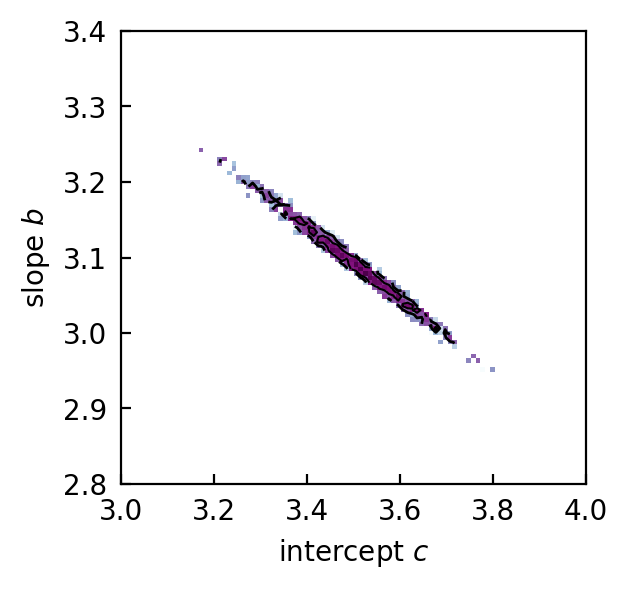

In [75]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[3.,4], ylim =[2.8,3.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

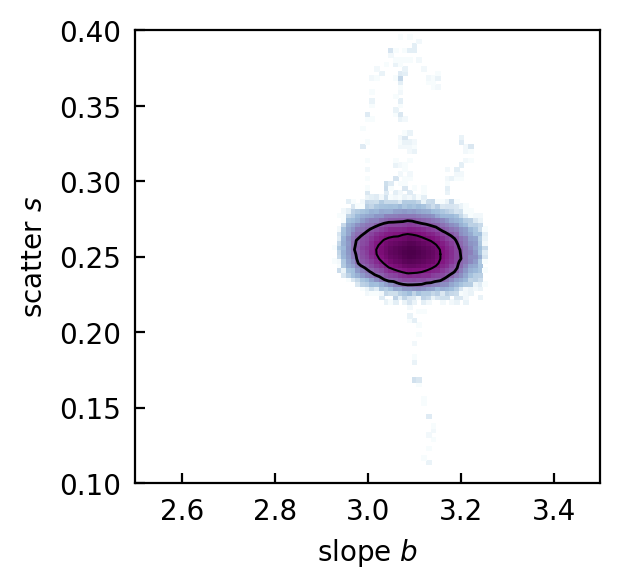

In [108]:
plot_2d_dist(chain[:,1], chain[:,2], xlim=[2.5,3.5], ylim =[0.1,0.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             ylabel=r'${\rm scatter}\ s$', 
             xlabel=r'${\rm slope}\ b$', figsize=(3,3))

In [79]:
def clims(a):
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = clims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = clims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [110]:
chain_stats(chain[:,0], param_name='intercept')
chain_stats(chain[:,1], param_name='slope')
chain_stats(chain[:,2], param_name='scatter')

============ statistics for intercept ============
mean, median = 3.509, 3.508, st.dev=0.0958
68 perc interval = 3.412, 3.605
95 perc interval = 3.318, 3.704
============ statistics for slope ============
mean, median = 3.094, 3.094, st.dev=0.0456
68 perc interval = 3.048, 3.140
95 perc interval = 3.001, 3.184
============ statistics for scatter ============
mean, median = 0.254, 0.253, st.dev=0.0086
68 perc interval = 0.245, 0.262
95 perc interval = 0.237, 0.271


The MOND model is excuded by this data in the context of this linear model. 

To fully carry this test fully requires exploring other types of linear models. We tested only one type of linear model with Gaussian scatter along y direction. We can also think about model with Gaussian scatter in the direction perpendicular to the line. This will give a somewhat larger slope, but still <4 with high significance. 

However, how certain are we in the statistical results above? Has the chain converged? Are the derived parameters and their uncertainties reliable? How many independent samples do we have in the chain?

In [80]:
def plot_trace(x, figsize=3):
    try:
        nsteps, ndims = np.shape(x)[0], np.shape(x)[1]
    except:
        nsteps, ndims = np.shape(x)[0], 1
        
    plt.figure(figsize=(figsize,figsize))
    for d in range(ndims):
        if ndims == 1:
            plt.plot(np.arange(0,nsteps,1), x, lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
        else:
            plt.plot(np.arange(0,nsteps), x[:,d], lw=0.5, c='darkslateblue', label='d={:d}'.format(d))
    plt.ylabel(r'$x$') # label axis 
    plt.xlabel(r'step number')
    plt.show()    

The first plot above shows that the slope and intercept are *linearly (anti) correlated* and correlation is very strong. We see also that the contours are poorly sampled despite many steps taken by MCMC. This is because with such large degeneracy, most random steps of size 0.1 are in the directions of very small likelihood values and so are rejected. The chain in this case has a large fraction of duplicate positions. 

Here is how it can be estimated. 

In [78]:
# step acceptance fraction
acc_frac = np.unique(chain).size/chain.size 
print(f'acceptance fraction = {acc_frac:.4f}')

acceptance fraction = 0.0119


So only $\approx 1.1\%$ of the samples are accepted for step size of 0.1. This can be increased if we use smaller steps, but then chains will take more steps for chain to converge. In the chain for step of 0.1 the trace plot for the intercept shown below shows that the chain has not fully converged (the caterpillar is not too "hairy" and we can see individual peaks and valleys, indicating that correlation length is large relative to the length of the chain). 

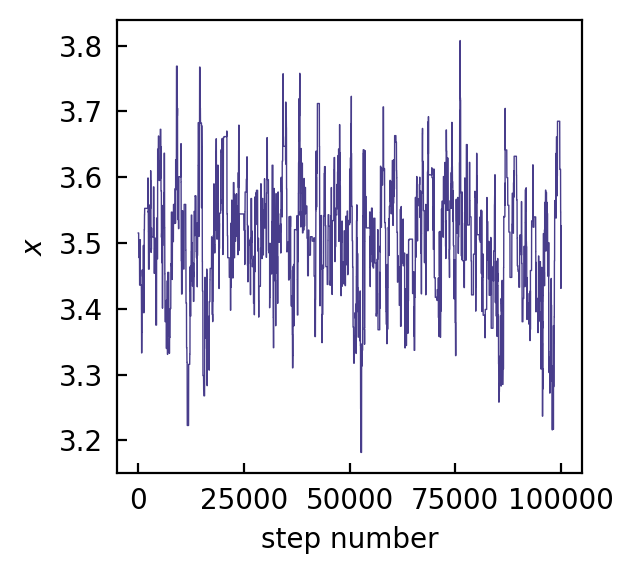

In [81]:
plot_trace(chain[:,0])

#### Pivoting

There is a relatively simple trick called **pivoting** that can help to largely remove the degeneracy, which will help MCMC sampling and increase accepted step fraction. 

Pivoting is simply shifting $x$ and $y$ of the data by their averages: $x^\prime = x -\bar{x}$, $y^\prime=y-\bar{y}$ and then use these pivoted $x^\prime$ and $y^\prime$ to infer the parameters. In the end, the intercept will need to be converted back to the original value, while slope is not affected by the shift, because it just moves all data points by constant value. 

Below is illustration for how this works. 

In [86]:
ndim = 3 # the model has 3 parameters 
nsteps = 100000 # number of MCMC steps
step = 0.05 # max step size (steps are random in [-step,step])

# simple pivoting
xp = x - np.average(x)
yp = y - np.average(y)

# pass data as arguments to the posterior pdf
args = [xp, ex**2, yp, ey**2]
# initialize at the best fit parameters
x0 = resl.x

chain = np.asarray(mcmc_simple(x0, nsteps, step, lnlinmodel_posterior, *args))

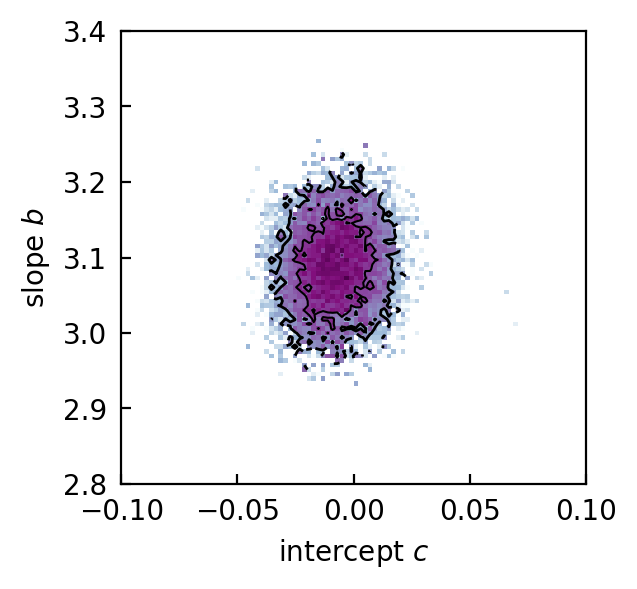

In [87]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[-0.1, 0.1], ylim =[2.8,3.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

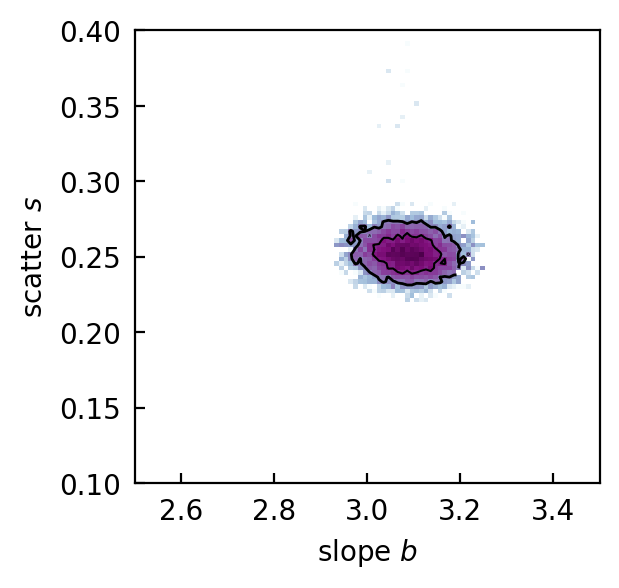

In [88]:
plot_2d_dist(chain[:,1], chain[:,2], xlim=[2.5,3.5], ylim =[0.1,0.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             ylabel=r'${\rm scatter}\ s$', 
             xlabel=r'${\rm slope}\ b$', figsize=(3,3))

In [89]:
def clims(a):
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = clims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = clims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [90]:
chain_stats(chain[:,0], param_name='intercept')
chain_stats(chain[:,1], param_name='slope')
chain_stats(chain[:,2], param_name='scatter')

============ statistics for intercept ============
mean, median = 0.003, -0.007, st.dev=0.1630
68 perc interval = -0.018, 0.004
95 perc interval = -0.028, 0.016
============ statistics for slope ============
mean, median = 3.092, 3.093, st.dev=0.0491
68 perc interval = 3.044, 3.141
95 perc interval = 2.993, 3.188
============ statistics for scatter ============
mean, median = 0.260, 0.254, st.dev=0.1102
68 perc interval = 0.245, 0.262
95 perc interval = 0.237, 0.272


Still for general (non-linear) models pivoting is not possible, although sometime a clever transformation of model parameters can make sampling easier. 

Also, the above contours for 10000 samples still look pretty noisy and one needs to be careful with the step size and the number of steps. 

###  <font color='blue'>Sampling using GW10 MCMC algorithm implemented in the emcee MCMC package</font>

A better sampling method, such as the affine-invariant method of Goodman & Weare (2010). Below is an example of how it works using its implementation in the <a href="https://emcee.readthedocs.io/en/v2.2.1/"><tt>emcee</tt></a> package. You can find installation instructions [here](https://emcee.readthedocs.io/en/v2.2.1/user/install/).  

In [109]:
# pass data as arguments to the posterior pdf
# no pivoting here
args = [x, ex**2, y, ey**2]
# initialize at the best fit parameters


In [118]:
import emcee

ndim, nwalkers, nsteps = 3, 50, 10000

# initialize walkers around best fit parameter values
p0 = np.zeros(((nwalkers, ndim)))
for d in range(ndim): 
    # generate Gaussian random numbers and shift the mean to the best fit values
    # 0.05 is a small dispersion around the mean. The exact value does not matter
    p0[:,d] = resl.x[d] + 0.05*np.random.normal(size=nwalkers)
    
# create an instance of the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim,  lnlinmodel_posterior, args=args)

# run for a given nsteps
dummy = sampler.run_mcmc(p0, nsteps)

# get chain
chain = np.array(sampler.chain)

In [110]:
chain.shape # shape is (nwalkers, nsteps, ndim)

(50, 10000, 3)

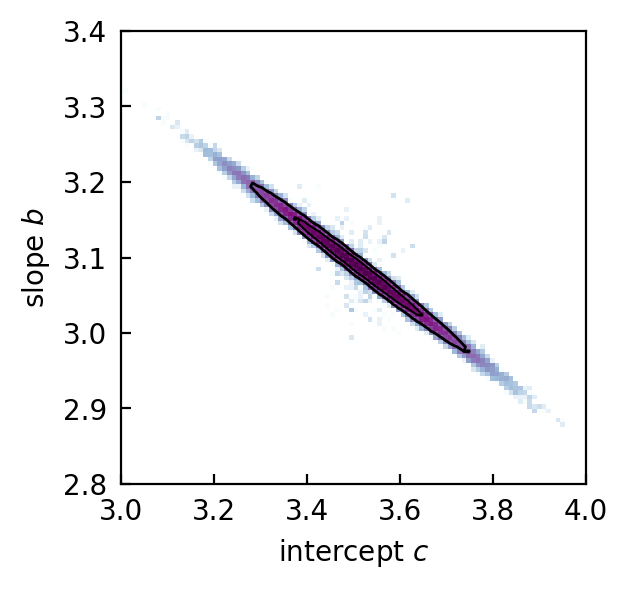

In [107]:
conflevs = [0.6827, 0.9545]

c = chain[:,:,0].flatten()
b = chain[:,:,1].flatten()
s = chain[:,:,2].flatten()


plot_2d_dist(c, b, xlim=[3, 4], ylim =[2.8,3.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

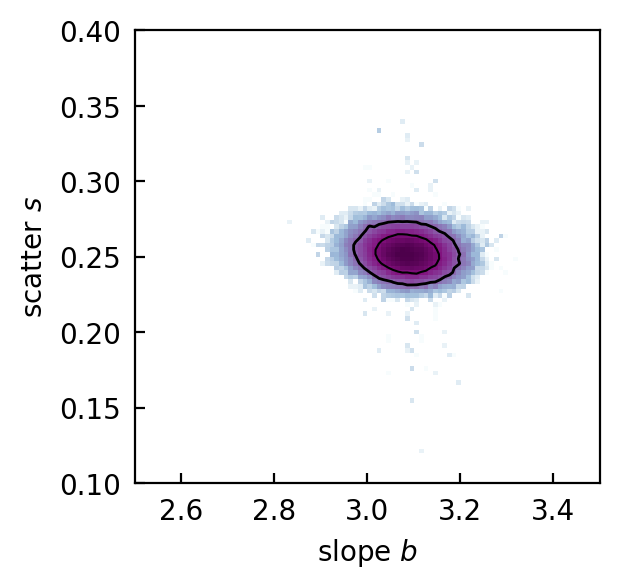

In [108]:
plot_2d_dist(b, s, xlim=[2.5,3.5], ylim =[0.1,0.4], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             ylabel=r'${\rm scatter}\ s$', 
             xlabel=r'${\rm slope}\ b$', figsize=(3,3))

We can see that the distribution is much better sampled, which is due to a much larger acceptance fraction. The large fraction of steps in this algorithm is because steps are taken along directions to other samples, so as samples arange along the degeneracy line of $b$ and $c$ most steps are along that line, not away from it as most steps in the standard MCMC would have. So most steps in the GW10 algorithm are in high probability areas. 

In [114]:
# step acceptance fraction
acc_frac = np.unique(c).size/c.size 
print(f'acceptance fraction = {acc_frac:.4f}')

acceptance fraction = 0.6465


The trace plot now looks very much like a hairy caterpillar, as shown below. We have to be careful here, because we need to look at the trace of individual "walkers". 

In [124]:
# take first 10 walkers and combine them into chain 100000 long
x = np.empty(0)
for i in range(10):
    x = np.hstack((x,chain[i,:,0]))

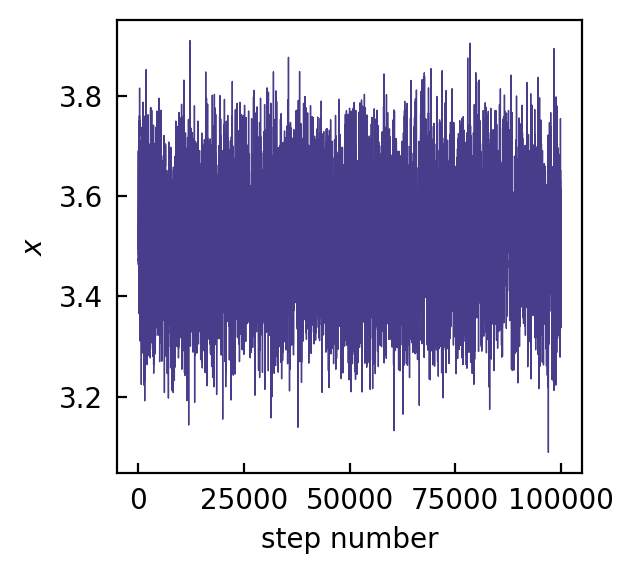

In [123]:
plot_trace(x)

In [111]:
def clims(a):
    x1 = 0.5*(100.-a)
    return x1, a + x1

def chain_stats(x, param_name='x'):
    """
    print mean, median, and confidence intervals for samples for a chain of sampled values
    for a *single* parameter
    """
    xmed = np.median(x); xm = np.mean(x); xsd = np.std(x)
    a = 68.268; 
    x1, x2 = clims(a)
    xcfl11 = np.percentile(x,x1); xcfl12 = np.percentile(x,x2)
    a = 95.452
    x1, x2 = clims(a)
    xcfl21 = np.percentile(x,x1); xcfl22 = np.percentile(x,x2)
    dashedline = '-------'
    print('============ statistics for {:s} ============'.format(param_name))
    print('mean, median = %.3f, %.3f, st.dev=%.4f'%(xm, xmed, xsd))
    print('68 perc interval = %.3f, %.3f'%(xcfl11, xcfl12))
    print('95 perc interval = %.3f, %.3f'%(xcfl21, xcfl22))


In [113]:
chain_stats(c, param_name='intercept')
chain_stats(b, param_name='slope')
chain_stats(s, param_name='scatter')

============ statistics for intercept ============
mean, median = 3.515, 3.515, st.dev=0.0960
68 perc interval = 3.418, 3.610
95 perc interval = 3.323, 3.707
============ statistics for slope ============
mean, median = 3.091, 3.091, st.dev=0.0457
68 perc interval = 3.045, 3.137
95 perc interval = 2.999, 3.182
============ statistics for scatter ============
mean, median = 0.254, 0.253, st.dev=0.0085
68 perc interval = 0.245, 0.262
95 perc interval = 0.237, 0.271


### <font color='darkblue'>Model comparison in Bayesian analysis (optional for undergraduate students)</font>


### <font color='darkblue'>Evidence of the model</font>
We often have competing models that can be aiming to describe the data. A simple example, is that if we don't know the form of the underlying trend we can consider a linear model like above and a quadratic model $y=ax^2 + bc + c$ as description for the data. How can we decide which model is better?
    
Two models are compared in the Bayesian analysis, by comparing their *odds*, where odds $O$, is defined as the probability given by the product of evidence and whatever prior probability the model had: 

$$
O(\mathcal{M})\equiv E(\mathcal{M})p(\mathcal{M}\vert I).
$$

where "evidence" is $E(\mathcal{M})=p({\rm data})$ in the expression for the Bayes theorem shown above and is a normalization factor that makes  the posterior distribution a proper pdf. 
Namely, the integral of the posterior pdf over the entire space of its parameters $\vec{\theta}$ should be 1:
    
$$\int \pi(\vec{\theta}|{\rm data}) d^D\vec{\theta}=1$$
    
By the Bayes theorem,     $\pi(\vec{\theta}|{\rm data})=p({\rm data}\vert\vec{\theta})p(\vec{\theta})/p({\rm data})$ so the integral above is
    
$$\int \frac{p({\rm data}\vert\vec{\theta})p(\vec{\theta})}{p({\rm data})}d^D\vec{\theta}=
\frac{1}{p({\rm data})}\int p({\rm data}\vert\vec{\theta})p(\vec{\theta})d^D\vec{\theta}=1,$$
where we can take   $p({\rm data})$ out of the integral because it does not depend on $\vec{\theta}$, so it's just a constant. So we have that the evidence is the integral of the product of the likelihood pdf and prior pdf over the entire parameter space. 
    
$$E(\mathcal{M})=p({\rm data})=\int p({\rm data}\vert\vec{\theta})p(\vec{\theta})d^D\vec{\theta}$$    
For example, if our current personal prior for the MOND model, $p(\mathcal{M}=\mathrm{MOND}\vert I)$ is very low, say $10^{-6}$, it needs to accumulate a large number of high evidences $E_i$ for a wide range of data, $\vec{d}_i$ to overcome the low value of starting bias and to get sizeable odds of being correct. However, even this process itself requires the MOND model to produce likelihoods for such observations, which is usually possible for a full-fledged predictive theory, but is often problematic for an ansatz like MOND.
 
### <font color='darkblue'>Model comparison using odds ratio</font>
By convention Bayesians consider compare two models, $\mathcal{M}_1$ and $\mathcal{M}_2$, using the *odds ratio*:

$$
 O_{21} =\frac{O(\mathcal{M}_2)}{O(\mathcal{M}_2)}=\frac{E(\mathcal{M}_2)p(\mathcal{M}_2\vert I)}{E(\mathcal{M}_1)p(\mathcal{M}_1\vert I)}\equiv B_{21}\frac{p(\mathcal{M}_2\vert I)}{p(\mathcal{M}_1\vert I)},
$$

 where $B_{21}\equiv E(\mathcal{M}_2)/E(\mathcal{M}_1)$ is called the *Bayes factor*. 


### <font color='darkblue'>Logic of the odds ratio

 The logic of the odds ratio can be grasped if we consider the case of likelihood given by the multi-variate Gaussian with flat prior pdf of parameters, $x_i$, over ranges $\Delta_{x_i}$: $p(x_i)=1/\Delta_{x_i}$. In this case the integral which gives the evidence will be proportional to $p_{\rm max}\sigma_{x_i}/\Delta_{x_i}$, where $\sigma_{x_i}$ is the rms of $x_i$. The better data constrains parameter $x_i$, the smaller the ratio $\sigma_{x_i}/\Delta_{x_i}$, although the overall evidence will generally in this case. 
    
For each added parameter, the evidence will be weighed by the factor $\sigma_{x_i}/\Delta_{x_i}$. If model adds parameters that are not constrained by the data, $\sigma_{x_i}\sim \Delta_{x_i}$, the evidence probability is not penalized for such additional parameters. However, if additional parameters are well constrained, each of them will penalize the evidence by multiplying it by its ratio $\sigma_{x_i}/\Delta_{x_i}$. 
    
    
Thus, to justify the additional parameters, the penalty needs to be compensated by increase of $p_{\rm max}$ and/or by larger prior ratio $p(\mathcal{M}_+\vert I)/p(\mathcal{M}\vert I)$ of model with more parameters, $\mathcal{M}_+$, compared to the fiducial model, $\mathcal{M}$. This is analogous to the well-known ``Occam's razor'' principle, which states that out of two models explaining observations equally well, a simpler model (i.e., model with fewer parameters) should be preferred.  

### <font color='darkblue'>Estimating evidence from MCMC samples

If $q(x)$ is a normalized pdf with dimensionality of the posterior, and $\pi(x)$ is a posterior with normalization constant (the evidence) $c_\pi = \int\pi(x)dx$, so that normalized posterior is $\tilde{\pi}=\pi/c_\pi$, we can write: 

$$
1 = \int q(x)\,dx = \int \frac{q(x)}{\pi(x)}\pi(x)dx = c_\pi \int \frac{q(x)}{\pi(x)}\frac{\pi(x)}{c_\pi}\,dx
$$

$$
=c_\pi \left\langle \frac{q}{\pi}\right\rangle_{\tilde{\pi}},\ \ \ \mathrm{so}\ \ \ c_\pi =  \left\langle \frac{q}{\pi}\right\rangle_{\tilde{\pi}}^{-1}
$$
    
    
Computatin of the evidence is straightforward, but in practice it is sensitive to noisy sampling of low-probability areas of the posterior pdf because it is computed using averages involving $1/\pi$, so regions of very low $\pi$ values can contribute a lot to the evidence, but due to small statistics the estimate of the evidence can become very noisy. 

### <font color='darkblue'> Bayesian Information Criterion (BIC) 

To compare models with posteriors sampled by MCMC amounts to evaluating the integral shown above. Sometimes it is difficult because accuracy of MCMC integration has low accuracy and we may not have sufficient number of samples to sample tails of the distribution sufficiently well. 
    
For this reason, instead of evaluating evidence properly the Bayesian Information Criterion (BIC) is often used as a short cut. The idea is that when parameters are well constrained the posterior is approximated by a multi-variate Gaussian can be used to approximate evidence. Namely, if we use the approximation of the evidence interval above as 
$$
E\approx p_{\rm max}\left(\frac{\sigma_{x_i}}{\Delta_{x_i}}\right)^d,
$$
where $p_{\rm max}$ is the maximum value of the likelihood among the positions of all $N$ data points, $d$ is the number of model parameters, $\sigma_{x_i}$ is the width of the posterior in $i$-th variable and $\Delta_{x_i}$ is effective width of the prior pdf in the same variable. 
    
If we assume that the widths of the posterior scale with the number of data points $N$ as $\sigma_{x_i}=c_i/\sqrt{N}$, and that for $N=1$ the posterior has the width of the prior, i.e. $c_i\sim \Delta_{x_i}$, we get $E\approx p_{\rm max} N^{-d/2}$.

The BIC estimator is defined as
$$
\mathrm{BIC} :=-2\ln E  \approx d\ln N - 2\ln p_{\rm max}
$$
    
Given its assumptions, BIC should be a good approximation for evidence when parameters are well constraibed (posterior pdf is close to multivariate Gaussian pdf), and will progressively less accurate is posterior pdf is not close to Gaussian.


### Recommended reading

* S 3.1-3.8 and S 2 of the <a href="http://adsabs.harvard.edu/abs/2017ARA%26A..55..213S">ARA&A review</a> by Sanjib Sharma on MCMC methods for Bayesian data analysis in astronomy.

